In [5]:
import jax
import flax
import jax.random as random
import flax.linen as nn
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from nde.density_estimator import DensityEstimator
from simulators.ou_simulator import OUSim

print('Jax version', jax.__version__)
print('Flax version', flax.__version__)

Jax version 0.4.8
Flax version 0.5.3


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

We are interested in carrying out Bayesian parameter inference of a stochastic dynamical system $\mathcal{M}_{\theta}$, parametrised by $\theta$. In particular, I am considering stochastic reaction networks that are modelled as a Markov jump process (MJP). Thus,  $\theta$ here describes the reaction rates.

So, lets assume we have some noisy time-series data $Y=(y_1,\ldots, y_T)$, observed at $T$ experimental time points, and we assume that these data are explained by a MJP $\mathcal{M}_{\theta}$. In a Bayesian framework we can place some prior $p(\theta)$ on the parameters and then write the posterior as:

$p(\theta|Y) \propto p(\theta)p(Y|\theta)$.

For MJPs (and many other interesting stochastic systems) $p(Y|\theta)$ is intractable and thus likelihood-free inference is required.

# Neural Likelihood-free inference

Recently, a series of papers have jointly popularised the idea of using a normalising-flow to carry out LFI. The basic idea is as follows:

- Simulate pairs of $\theta, Y$ from their joint distribution and create a training dataset, of $N$ samples $\{\theta^n,Y^n\}_{n=1}^N$.
- Train a conditional density estimator (a normalising-flow) $q_{\psi}(\theta|s(Y))$ using this training dataset, where $s(Y)$ is a summary of $Y$.
- The trained density estimator then becomes an approximation to the posterior $p(\theta|Y)\approx q_{\psi}(\theta|s(Y))$.
-  Draw samples $\theta \sim q_{\psi}(\theta|s(Y_o))$ by conditioning on a particular dataset $Y_o$.
   


# Working example: The Ornstein–Uhlenbeck diffusion process

The OU process is linear SDE and thus has a tractable transition density. Strictly speaking we don't need LFI here. However, this is a simple enough model to illustrate the basics of NLFI and thus I have chosen it. Besides, the OU process had been used in numerous benchmarking studies related to inference of stochastic processes. The OU process is given by the following linear SDE:
$dx_t = c_1(c_2 -x_t)dt + c_3 dw_t$,

with parameters: $\theta=(c_1,c_2,c_3)$.
Lets generate some fake data using the simulator class we have defined for this model

In [13]:
simulator = OUSim(simulate_summary=False)
true_param = np.array([[0.1, .5, 0.01],[0.1, .5, 0.01]])
fake_data  = simulator(true_param)


Simulation started
Simulation Finished


(100,)

(0.0, 10.0)

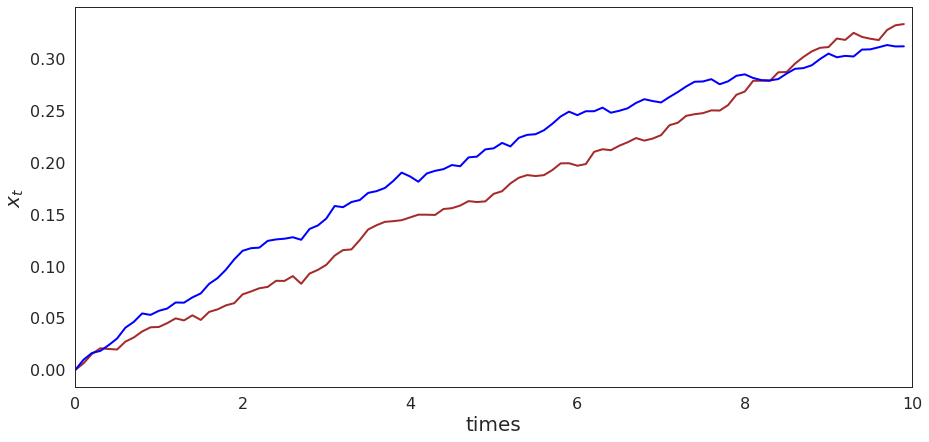

In [20]:
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(15, 7),"font.size":20,"axes.titlesize":20,"axes.labelsize":16,"axes.linewidth":1,
    "xtick.labelsize":16, "ytick.labelsize":16},style="white")
times = np.arange(0,10,.1)


plt.plot(times,fake_data.squeeze()[0,:],color='brown', lw=2)
plt.plot(times,fake_data.squeeze()[1,:],color='blue', lw=2)
plt.ylabel(r"$x_t$", fontsize=20)
plt.xlabel('times', fontsize=20)
plt.xlim([0,10])


     


## Training a flow on simulated dataset

Now lets generate a large enough training set using this simulator and train a normalising-flow. We have implemented a coupling based flow architecture (basically a modification of real-NVP flow) that was used in [here](https://arxiv.org/pdf/2003.06281.pdf). However, before we invoke training we need to do two more things:
- Set priors: a function that simulates $N$ samples from $p(\theta)$.

In [21]:
def priors(N):
  p_samples = np.random.gamma(2,1/2,size=(N, 3))
  
  return p_samples.astype(np.float32)

- Set summary statistics. Rather than handcrafting such summaries, we are going learn the summary by using a summariser neural network. We will use a LSTM.

In [22]:
class SummariserLSTM(nn.Module):
  features: int
  @nn.compact
  def __call__(self, x):
    batch_size = x.shape[0]
    cell = nn.LSTMCell()
    def body_fn(cell, carry, x):
      carry, y = cell(carry, x)
      return carry, y

    scan = nn.scan(
      body_fn, variable_broadcast="params",
      split_rngs={"params": False}, in_axes=1, out_axes=1)

    carry = nn.LSTMCell.initialize_carry(random.PRNGKey(20), \
                                (batch_size,), self.features)

    carry, x = scan(cell, carry, x)
    x = nn.Dense(self.features,kernel_init=nn.initializers.glorot_uniform(),
                            bias_init=nn.initializers.zeros)(x)
    x = nn.relu(x)

    return x[...,-1,:]
summariser = SummariserLSTM(20)

We can now go ahead and train all the neural networks: 1) the normalising-flow based conditional density estimator and 2) the LSTM summariser

we set the total number of simulations `n_sim=50000`

In [23]:
network_settings ={
    'hidden_features': [64, 64, 64, 64],
    'n_blocks': 5}

estimator = DensityEstimator(simulator, priors, network_settings, summariser=summariser)


In [24]:
trained_network, trained_weights = estimator.train(n_sim=50000)

Simulation started
Simulation Finished
Simulation started
Simulation Finished


/home/sanmitra/anaconda3/envs/vbode/lib/python3.9/site-packages/flax/core/lift.py:112: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  scopes, treedef = jax.tree_flatten(scope_tree)
/home/sanmitra/anaconda3/envs/vbode/lib/python3.9/site-packages/flax/core/lift.py:723: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(x)
/home/sanmitra/anaconda3/envs/vbode/lib/python3.9/site-packages/flax/core/lift.py:729: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lengths = set(jax.tree_leaves(lengths))
/home/sanmitra/anaconda3/envs/vbode/lib/python3.9/site-packages/flax/core/axes_scan.py:134: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  in_avals, in_tre

Density Estimator Converged


## Sampling from posterior

We are basically done! We have an approximation  $p(\theta|Y)\approx q_{\psi}(\theta|s(Y))$, with $s(Y)=LSTM(Y)$, from which we can draw samples by conditioning with the actual observed data $Y_o$. In our case that is the `fake_data` we have prviosuly generated.

In [25]:
nlfi_params = estimator.posterior_samples(random.PRNGKey(1), fake_data, trained_network, trained_weights, n_samples=1000)

Finally some marginal posterior plots...

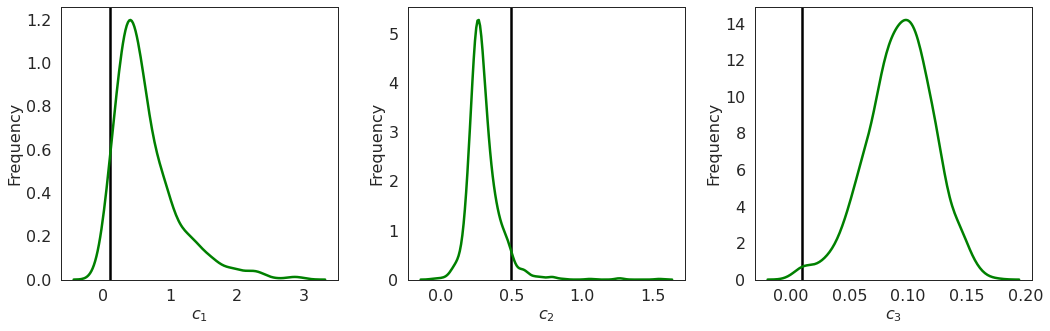

In [27]:
param_names = [r"$c_1$",r"$c_2$", r"$c_3$"]
real_params = np.array([0.1, .5, 0.01])
plt.figure(figsize=(15,5))
for i, p in enumerate(param_names):        
        
        plt.subplot(1, 3, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:

                sns.kdeplot(nlfi_params[:, 0, i], color='green', linewidth = 2.5)
                plt.ylabel('Frequency')
                plt.xlabel(param_names[i]) 
        else:
                sns.kdeplot(nlfi_params[:, 0, i], linewidth = 2.5, color='green') 

                plt.ylabel('Frequency')
                plt.xlabel(param_names[i])        
                
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.show() 